## **Generate a dataset of concatenated images with "left" and "right" cue patches**
Author: patrick.mccarthy@dtc.ox.ac.uk

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils import create_data_loaders, add_cue_patch

ModuleNotFoundError: No module named 'utils'

In [3]:
dataset = "MNIST"
norm = "normalise"
save_path = "/Users/patmccarthy/Documents/thalamocortex/data"
batch_size = 32

Load source dataset

In [4]:
trainset_loader, testset_loader, metadata = create_data_loaders(dataset=dataset,
                                                                norm=norm,
                                                                save_path=save_path,
                                                                batch_size=batch_size)

In [5]:
# load full training set
X_all = []
y_all = []
for X, y in iter(trainset_loader):
    X_all.append(X.detach().numpy()[:, 0, :, :])
    y_all.append(y.detach().numpy()[:])
for X, y in iter(testset_loader):
    X_all.append(X.detach().numpy()[:, 0, :, :])
    y_all.append(y.detach().numpy()[:])
X_all_arr = np.array(X_all)
y_all_arr = np.array(y_all)
# get all samples into one array
X_all_reshaped = np.zeros([X_all_arr.shape[0] * X_all_arr[0].shape[0], X_all_arr[0].shape[1], X_all_arr[0].shape[2]])
y_all_reshaped = np.zeros([y_all_arr.shape[0] * y_all_arr[0].shape[0]])
new_idx = 0
for batch_idx, X_batch in enumerate(X_all_arr):
    for point_idx, _ in enumerate(X_batch):
        X_all_reshaped[new_idx, ...] = X_all_arr[batch_idx][point_idx, :, :]
        y_all_reshaped[new_idx] = y_all_arr[batch_idx][point_idx]
        new_idx += 1

/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_3538/3371650113.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_all_arr = np.array(X_all)
/var/folders/4g/1kv65jgx1x1558h12tz57s580000gn/T/ipykernel_3538/3371650113.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_all_arr = np.array(y_all)


In [6]:
y_all_reshaped

array([2., 3., 6., ..., 0., 0., 0.])

Generate new dataset

In [7]:
cue_params = {"size": [2, 2],
              "margin": [0, 0],
              "left": {"location": "tl",
                       "intensity": 1},
              "right": {"location": "tr",
                       "intensity": 1}}

In [8]:
# create combined image dataset with cue patches
X_new = np.empty([X_all_reshaped.shape[0]//2, X_all_reshaped.shape[1], X_all_reshaped.shape[1] * 2])
y_new = np.empty([y_all_reshaped.shape[0]//2])
sides = []
for new_idx, old_idx in enumerate(np.arange(0, X_all_reshaped.shape[0], 2)):

    # get side and target
    if new_idx % 2 == 0:
        side = "left"
        y = y_all_reshaped[old_idx]
    else:
        side = "right"
        y = y_all_reshaped[old_idx+1]

    # generate combined image
    img_combined = np.concatenate((X_all_reshaped[old_idx],  X_all_reshaped[old_idx+1]), axis=1)

    # add cue
    X = add_cue_patch(img_combined, cue_params, side)

    # add images to new dataset
    X_new[new_idx, :, :] = X
    y_new[new_idx] = y
    sides.append(side)

In [9]:
y_new

array([2., 5., 6., ..., 0., 0., 0.])

Text(0.5, 1.0, 'target: 2')

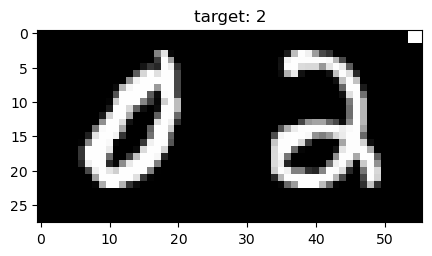

In [10]:
# plot example image as sanity check
idx = 5
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.imshow(X_new[idx], cmap="gray")
ax.set_title(f"target: {y_new[idx]:.0f}, target side: {sides[idx]}")

Save new dataset

In [11]:
X_new.shape

(35008, 28, 56)

In [12]:
# split into train and test sets
train_test_split = 0.8
num_train_samples = np.floor(X_new.shape[0] * train_test_split).astype(int)
train_data = {"X": X_new[:num_train_samples, ...],
              "y": y_new[:num_train_samples],
              "sides": sides[:num_train_samples]}
test_data = {"X": X_new[num_train_samples:, ...],
             "y": y_new[num_train_samples:],
             "sides": sides[num_train_samples:]}

In [13]:
# save dataset
save_folder = Path(save_path, "LeftRightMNIST")
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
with open(Path(save_folder, "train.pkl"), "wb") as handle:
    pickle.dump(train_data, handle)
with open(Path(save_folder, "test.pkl"), "wb") as handle:
    pickle.dump(test_data, handle)

Test loading dataset

In [14]:
dataset_path = "/Users/patmccarthy/Documents/thalamocortex/data/LeftRightMNIST/train.pkl"

In [15]:
trainset_loader, testset_loader, metadata = create_data_loaders("LeftRightMNIST", "normalise", 32, "/Users/patmccarthy/Documents/thalamocortex/data")

In [16]:
X, y = next(iter(trainset_loader))